# Cochlear Implant Signal Processing Demo

This interactive demonstration shows how cochlear implants process speech signals.
You'll explore each stage of the signal processing pipeline:

1. **Input Speech** → Original audio waveform
2. **Filterbank Analysis** → Splitting into frequency channels
3. **Envelope Extraction** → Extracting amplitude modulation
4. **n-of-m Channel Selection** → Selecting most energetic channels
5. **Compression Mapping** → Mapping acoustic to electrical range
6. **Vocoder Reconstruction** → Creating audible simulation

Use the interactive controls below to adjust parameters and hear how they affect the output!

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Output
import librosa

# Import our CI processing modules
import sys

sys.path.insert(0, "..")

from src.filterbank import CochlearFilterbank
from src.envelope import extract_envelope, EnvelopeExtractor
from src.channel_selection import ChannelSelector, select_channels_n_of_m
from src.compression import AmplitudeCompressor, compress_amplitude
from src.vocoder import CochlearVocoder, vocode_noise

# Set up matplotlib style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

print("All modules loaded successfully!")

ImportError: cannot import name 'vocode_sine' from 'src.vocoder' (/home/xhao/proj/cochlear_implant_sonification/notebooks/../src/vocoder.py)

## 1. Load Sample Audio

First, let's load a sample speech signal. We'll use a simple synthesized speech sample for this demo.

✅ Loaded audio sample: 2.00 seconds

🔊 Original Audio:


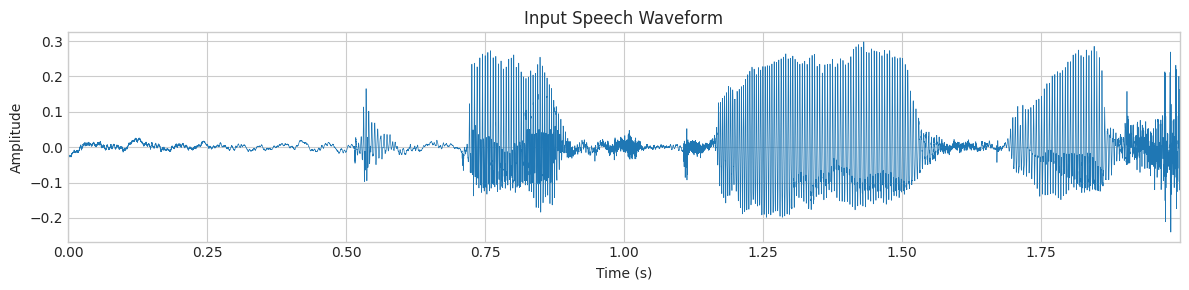

In [ ]:
# Load audio file using librosa
SAMPLE_RATE = 16000  # 16 kHz
DURATION = 2.0  # Use 2 seconds for demo

# Load audio - will raise error if file not found
audio, sr = librosa.load("../audio/sample.wav", sr=SAMPLE_RATE, duration=DURATION)
print(f"Loaded audio sample: {len(audio) / SAMPLE_RATE:.2f} seconds")

# Display original audio
print("\nOriginal Audio:")
display(Audio(audio, rate=SAMPLE_RATE))

# Plot waveform
fig, ax = plt.subplots(figsize=(12, 3))
time = np.arange(len(audio)) / SAMPLE_RATE
ax.plot(time, audio, linewidth=0.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Input Speech Waveform")
ax.set_xlim([0, time[-1]])
plt.tight_layout()
plt.show()

## 2. Filterbank Analysis

The first stage divides the input signal into multiple frequency bands.
Cochlear implants typically use 12-22 channels. Here we use **Mel-scale spacing**
for educational simplicity.

> **Note**: Real cochlear implants use the **Greenwood function** instead of Mel scale.
> The Greenwood function maps cochlear position to characteristic frequency based on
> the physical properties of the human cochlea, providing more accurate tonotopic mapping.

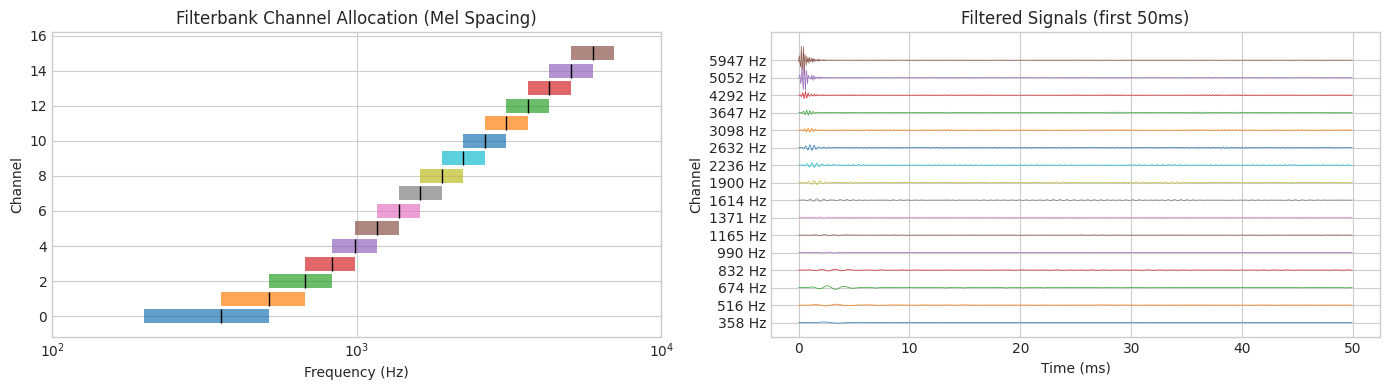

📊 Created 16-channel filterbank
   Frequency range: 200 - 7000 Hz


In [ ]:
# Create filterbank
N_CHANNELS = 16  # Default number of channels

filterbank = CochlearFilterbank(
    n_channels=N_CHANNELS,
    sample_rate=SAMPLE_RATE,
    freq_low=200,
    freq_high=7000,
)

# Apply filterbank
filtered = filterbank.filter(audio)

# Plot filterbank frequency response
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Channel frequency allocation
ax1 = axes[0]
for i in range(N_CHANNELS):
    ax1.barh(
        i,
        filterbank.band_edges[i, 1] - filterbank.band_edges[i, 0],
        left=filterbank.band_edges[i, 0],
        height=0.8,
        alpha=0.7,
    )
    ax1.plot(filterbank.center_freqs[i], i, "k|", markersize=10)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Channel")
ax1.set_title("Filterbank Channel Allocation (Mel Spacing)")
ax1.set_xscale("log")
ax1.set_xlim([100, 10000])

# Right: Filtered signals (first 50ms)
ax2 = axes[1]
show_samples = int(0.05 * SAMPLE_RATE)
time_ms = np.arange(show_samples) / SAMPLE_RATE * 1000

for i in range(N_CHANNELS):
    offset = i * 0.5
    signal_norm = (
        filtered[i, :show_samples] / (np.max(np.abs(filtered[i, :])) + 1e-10) * 0.4
    )
    ax2.plot(time_ms, signal_norm + offset, linewidth=0.5)

ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Channel")
ax2.set_title("Filtered Signals (first 50ms)")
ax2.set_yticks(np.arange(N_CHANNELS) * 0.5)
ax2.set_yticklabels([f"{int(f)} Hz" for f in filterbank.center_freqs])

plt.tight_layout()
plt.show()

print(f"Created {N_CHANNELS}-channel filterbank")
print(f"   Frequency range: {filterbank.freq_low} - {filterbank.freq_high} Hz")

## 3. Envelope Extraction

For each frequency channel, we extract the **temporal envelope** - the slowly-varying
amplitude modulation. This is done by:
1. Half-wave rectification (keeping only positive values)
2. Lowpass filtering (typically 200-500 Hz cutoff)

The envelope carries critical speech information like formant transitions.

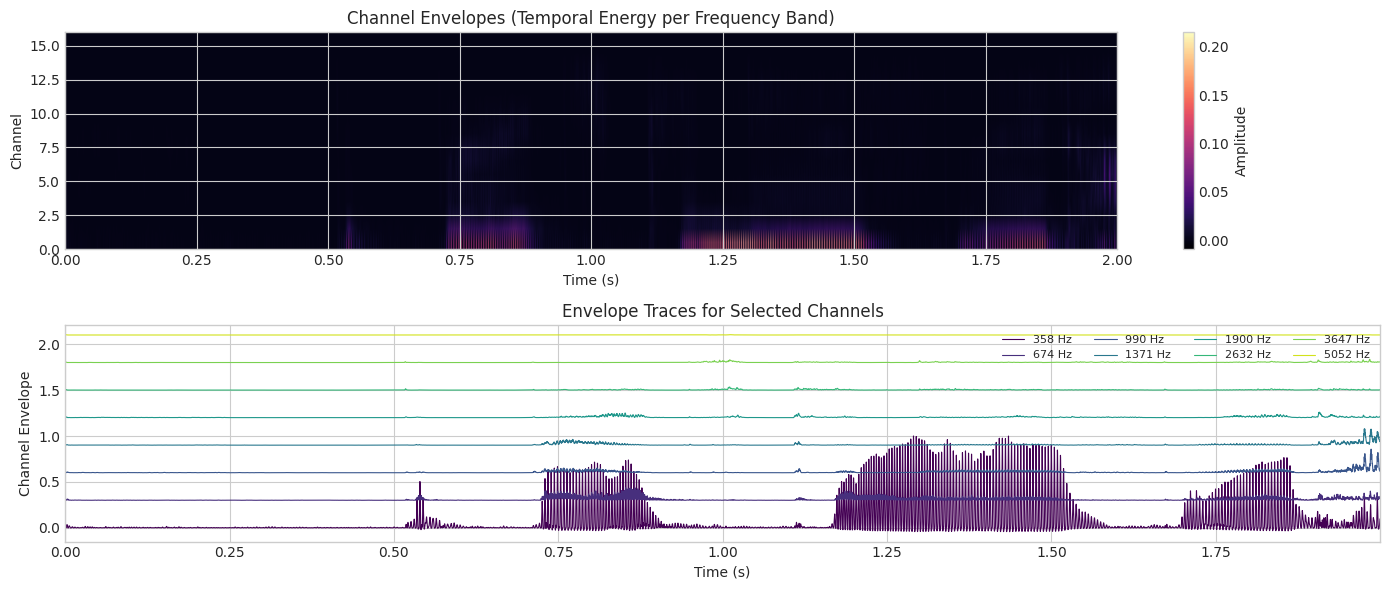

📊 Extracted envelopes with 400 Hz lowpass cutoff


In [ ]:
# Extract envelopes
ENVELOPE_CUTOFF = 400  # Hz

extractor = EnvelopeExtractor(
    sample_rate=SAMPLE_RATE,
    method="rectify",
    cutoff_freq=ENVELOPE_CUTOFF,
)

envelopes = extractor.extract(filtered)

# Plot envelopes as spectrogram-like heatmap
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Top: Envelope heatmap
ax1 = axes[0]
extent = [0, len(audio) / SAMPLE_RATE, 0, N_CHANNELS]
im = ax1.imshow(
    envelopes,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="magma",
    interpolation="bilinear",
)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Channel")
ax1.set_title("Channel Envelopes (Temporal Energy per Frequency Band)")
plt.colorbar(im, ax=ax1, label="Amplitude")

# Bottom: Individual envelope traces
ax2 = axes[1]
time = np.arange(len(audio)) / SAMPLE_RATE
colors = plt.cm.viridis(np.linspace(0, 1, N_CHANNELS))

for i in range(0, N_CHANNELS, 2):  # Show every other channel
    env_norm = envelopes[i, :] / (np.max(envelopes) + 1e-10)
    ax2.plot(
        time,
        env_norm + i * 0.15,
        color=colors[i],
        linewidth=0.8,
        label=f"{int(filterbank.center_freqs[i])} Hz",
    )

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Channel Envelope")
ax2.set_title("Envelope Traces for Selected Channels")
ax2.legend(loc="upper right", fontsize=8, ncol=4)
ax2.set_xlim([0, time[-1]])

plt.tight_layout()
plt.show()

print(f"Extracted envelopes with {ENVELOPE_CUTOFF} Hz lowpass cutoff")

## 4. n-of-m Channel Selection

Not all channels are stimulated simultaneously. The **ACE (Advanced Combination Encoder)**
strategy selects only the **n** channels with highest energy in each time frame.

This reduces:
- Power consumption (fewer electrodes stimulated)
- Channel interaction (less current spread)
- While maintaining speech intelligibility!

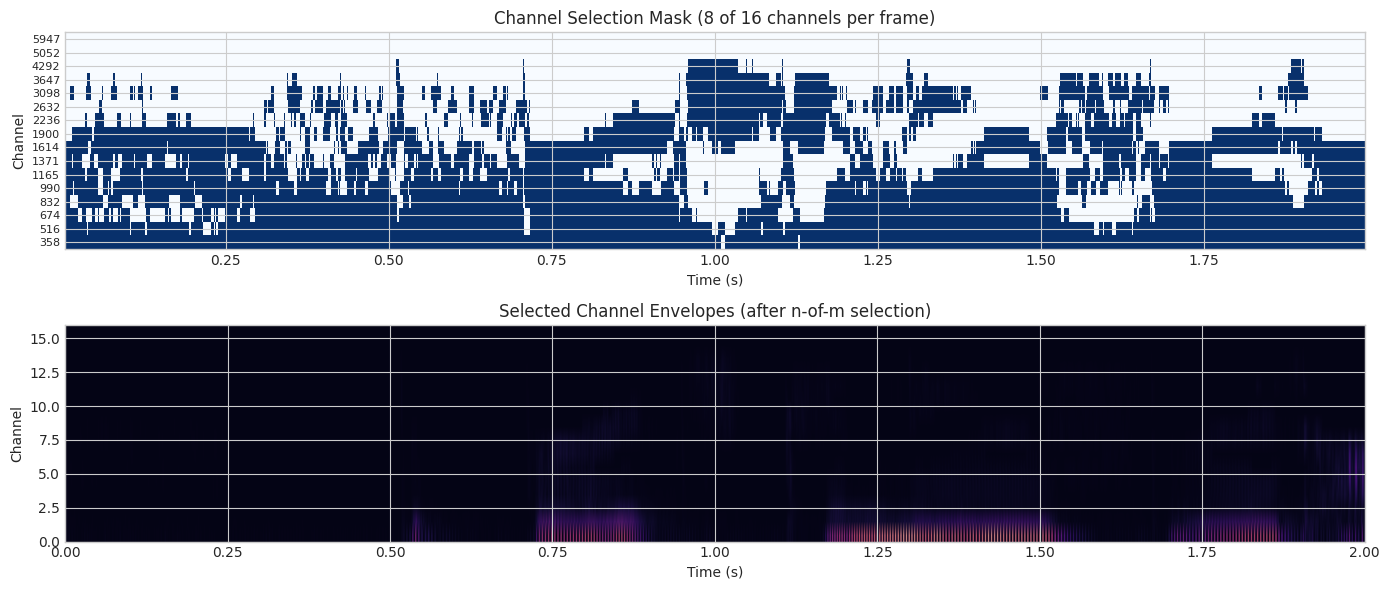

📊 Channel Selection Statistics:
   Channels per frame: 8 of 16
   Total frames: 997
   Frame rate: 500000.0 frames/sec


In [ ]:
# Apply n-of-m selection
N_SELECT = 8  # Select 8 of 16 channels

selector = ChannelSelector(
    n_select=N_SELECT,
    n_total=N_CHANNELS,
    frame_ms=8,
    hop_ms=2,
)

selection_result = selector.select(envelopes, SAMPLE_RATE)
selected_envelopes = selection_result["selected_envelopes"]
selection_mask = selection_result["mask"]
frame_times = selection_result["frame_times"]

# Plot selection results
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Top: Selection mask (which channels are active)
ax1 = axes[0]
extent = [frame_times[0], frame_times[-1], 0, N_CHANNELS]
ax1.imshow(
    selection_mask.astype(float),
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="Blues",
    interpolation="nearest",
)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Channel")
ax1.set_title(f"Channel Selection Mask ({N_SELECT} of {N_CHANNELS} channels per frame)")

# Add channel frequency labels
ax1.set_yticks(np.arange(N_CHANNELS) + 0.5)
ax1.set_yticklabels([f"{int(f)}" for f in filterbank.center_freqs], fontsize=8)

# Bottom: Selected vs original envelopes
ax2 = axes[1]
extent = [0, len(audio) / SAMPLE_RATE, 0, N_CHANNELS]
ax2.imshow(
    selected_envelopes,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="magma",
    interpolation="bilinear",
)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Channel")
ax2.set_title("Selected Channel Envelopes (after n-of-m selection)")

plt.tight_layout()
plt.show()

# Calculate selection statistics
active_per_frame = np.sum(selection_mask, axis=0)
print(f"Channel Selection Statistics:")
print(f"   Channels per frame: {N_SELECT} of {N_CHANNELS}")
print(f"   Total frames: {len(frame_times)}")
print(f"   Frame rate: {1000 / (frame_times[1] - frame_times[0]):.1f} frames/sec")

## 5. Compression Mapping

The acoustic dynamic range (~100 dB) is much larger than the electrical
dynamic range perceived by CI users (~10-20 dB). Logarithmic compression
maps the acoustic amplitudes to appropriate stimulation levels.

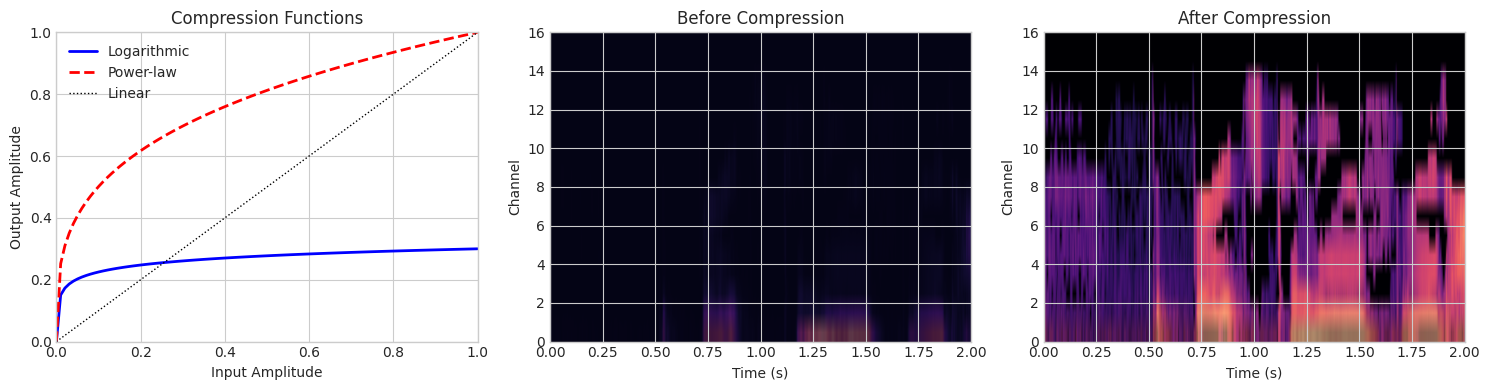

📊 Applied logarithmic compression (ratio: 0.3)


In [ ]:
# Apply compression
COMPRESSION_RATIO = 0.3

compressor = AmplitudeCompressor(
    method="logarithmic",
    compression_ratio=COMPRESSION_RATIO,
)

compressed = compressor.compress(selected_envelopes)

# Plot compression effect
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Left: Compression function
ax1 = axes[0]
x = np.linspace(0, 1, 100)
y_log = compress_amplitude(x, method="logarithmic")
y_pow = compress_amplitude(x, method="power", exponent=0.3)
ax1.plot(x, y_log, "b-", linewidth=2, label="Logarithmic")
ax1.plot(x, y_pow, "r--", linewidth=2, label="Power-law")
ax1.plot(x, x, "k:", linewidth=1, label="Linear")
ax1.set_xlabel("Input Amplitude")
ax1.set_ylabel("Output Amplitude")
ax1.set_title("Compression Functions")
ax1.legend()
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Middle: Before compression
ax2 = axes[1]
extent = [0, len(audio) / SAMPLE_RATE, 0, N_CHANNELS]
ax2.imshow(
    selected_envelopes,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="magma",
    interpolation="bilinear",
)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Channel")
ax2.set_title("Before Compression")

# Right: After compression
ax3 = axes[2]
ax3.imshow(
    compressed,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="magma",
    interpolation="bilinear",
)
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Channel")
ax3.set_title("After Compression")

plt.tight_layout()
plt.show()

print(f"Applied logarithmic compression (ratio: {COMPRESSION_RATIO})")

## 6. Vocoder Reconstruction

To create an audible simulation of what CI users perceive, we use a **noise-band vocoder**:
- Each channel's envelope modulates a bandpass-filtered noise carrier
- Noise carriers are more realistic because CI electrodes produce broadband electrical stimulation

Listen to the comparison!

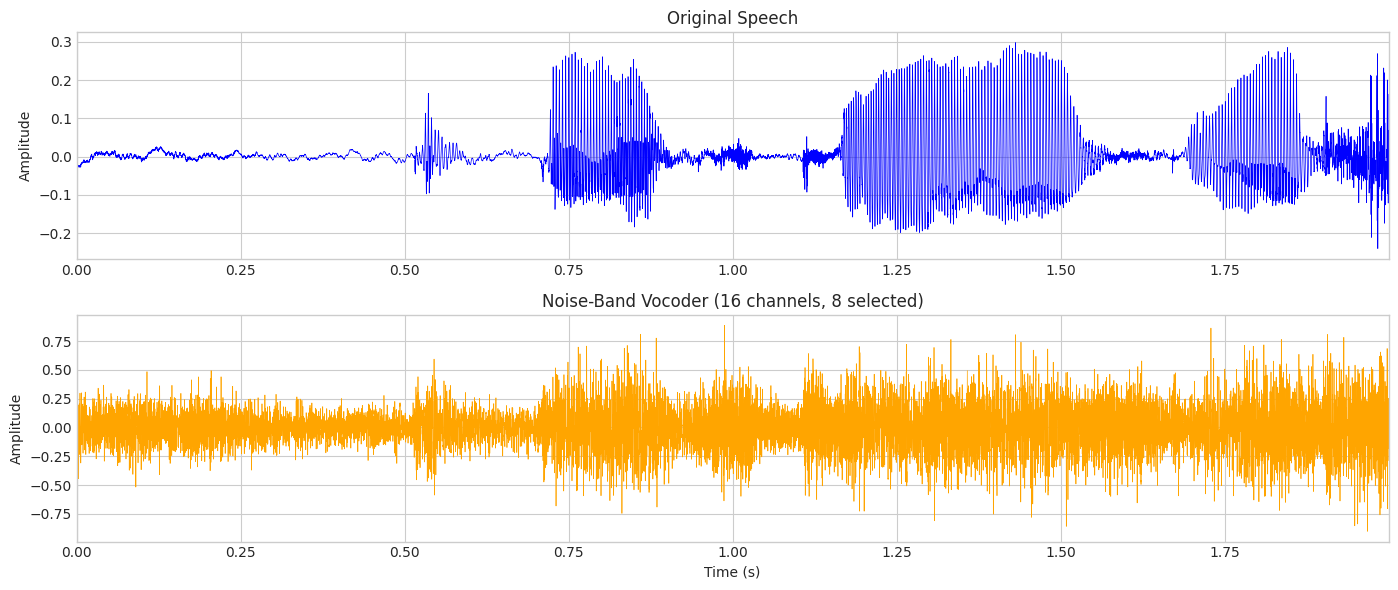


🔊 Listen and Compare:

▶️ Original Audio:



▶️ Noise-Band Vocoder (CI simulation):


In [ ]:
# Generate vocoded output using noise-band vocoder
vocoded = vocode_noise(compressed, filterbank.band_edges, SAMPLE_RATE)

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

time = np.arange(len(audio)) / SAMPLE_RATE

# Original
ax1 = axes[0]
ax1.plot(time, audio, "b", linewidth=0.5)
ax1.set_ylabel("Amplitude")
ax1.set_title("Original Speech")
ax1.set_xlim([0, time[-1]])

# Noise vocoder
ax2 = axes[1]
ax2.plot(time, vocoded, "orange", linewidth=0.5)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude")
ax2.set_title(f"Noise-Band Vocoder ({N_CHANNELS} channels, {N_SELECT} selected)")
ax2.set_xlim([0, time[-1]])

plt.tight_layout()
plt.show()

# Audio players
print("\nListen and Compare:")
print("\nOriginal Audio:")
display(Audio(audio, rate=SAMPLE_RATE))

print("\nNoise-Band Vocoder (CI simulation):")
display(Audio(vocoded, rate=SAMPLE_RATE))

---

## Interactive Demo

Now try adjusting the parameters yourself! See how each setting affects
the vocoded output.

In [ ]:
# Interactive vocoder demo
output_area = Output()


def run_vocoder(n_channels, n_select, envelope_cutoff):
    """Run the complete vocoder pipeline with given parameters."""
    with output_area:
        output_area.clear_output(wait=True)

        # Create vocoder with current parameters
        vocoder = CochlearVocoder(
            n_channels=n_channels,
            sample_rate=SAMPLE_RATE,
            freq_low=200,
            freq_high=7000,
            n_select=n_select,
            envelope_cutoff=envelope_cutoff,
        )

        # Process audio
        result = vocoder.process(audio, return_intermediate=True)

        # Plot results
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))

        # Channel envelopes
        ax1 = axes[0, 0]
        extent = [0, len(audio) / SAMPLE_RATE, 0, n_channels]
        ax1.imshow(
            result["envelopes"],
            aspect="auto",
            origin="lower",
            extent=extent,
            cmap="magma",
        )
        ax1.set_title("Channel Envelopes")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Channel")

        # Selection mask
        ax2 = axes[0, 1]
        extent = [result["frame_times"][0], result["frame_times"][-1], 0, n_channels]
        ax2.imshow(
            result["selection_mask"].astype(float),
            aspect="auto",
            origin="lower",
            extent=extent,
            cmap="Blues",
        )
        ax2.set_title(f"Channel Selection ({n_select} of {n_channels})")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Channel")

        # Compressed envelopes
        ax3 = axes[1, 0]
        extent = [0, len(audio) / SAMPLE_RATE, 0, n_channels]
        ax3.imshow(
            result["compressed"],
            aspect="auto",
            origin="lower",
            extent=extent,
            cmap="magma",
        )
        ax3.set_title("Compressed Envelopes")
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Channel")

        # Waveform comparison
        ax4 = axes[1, 1]
        time = np.arange(len(audio)) / SAMPLE_RATE
        ax4.plot(time, audio, "b", alpha=0.5, linewidth=0.5, label="Original")
        ax4.plot(time, result["vocoded"], "orange", linewidth=0.5, label="Vocoded")
        ax4.set_title("Waveform Comparison")
        ax4.set_xlabel("Time (s)")
        ax4.set_ylabel("Amplitude")
        ax4.legend()
        ax4.set_xlim([0, time[-1]])

        plt.tight_layout()
        plt.show()

        # Audio output
        print(f"\nVocoded Output ({n_channels} channels, {n_select} selected):")
        display(Audio(result["vocoded"], rate=SAMPLE_RATE))


# Create widgets
n_channels_slider = widgets.IntSlider(
    value=16,
    min=4,
    max=22,
    step=1,
    description="Channels:",
    style={"description_width": "100px"},
)

n_select_slider = widgets.IntSlider(
    value=8,
    min=1,
    max=22,
    step=1,
    description="Select (n):",
    style={"description_width": "100px"},
)

envelope_slider = widgets.IntSlider(
    value=400,
    min=50,
    max=1000,
    step=50,
    description="Env. Cutoff:",
    style={"description_width": "100px"},
)


# Link n_select max to n_channels
def update_n_select_max(*args):
    n_select_slider.max = n_channels_slider.value
    if n_select_slider.value > n_channels_slider.value:
        n_select_slider.value = n_channels_slider.value


n_channels_slider.observe(update_n_select_max, "value")

# Run button
run_button = widgets.Button(
    description="Process Audio",
    button_style="primary",
    icon="play",
)


def on_run_click(b):
    run_vocoder(
        n_channels_slider.value,
        n_select_slider.value,
        envelope_slider.value,
    )


run_button.on_click(on_run_click)

# Layout
controls = VBox(
    [
        HBox([n_channels_slider, n_select_slider]),
        HBox([envelope_slider, run_button]),
    ]
)

display(HTML("<h3>Adjust Parameters and Click 'Process Audio':</h3>"))
display(controls)
display(output_area)

# Initial run
run_vocoder(16, 8, 400)

Output()

---

## Summary

This demo showed the complete cochlear implant signal processing pipeline:

| Stage | Description | Key Parameter |
|-------|-------------|---------------|
| 1. **Filterbank** | Divide signal into frequency bands | Number of channels (4-22) |
| 2. **Envelope** | Extract amplitude modulation | Cutoff frequency (50-1000 Hz) |
| 3. **n-of-m Selection** | Select most energetic channels | n channels per frame |
| 4. **Compression** | Map acoustic to electrical range | Compression ratio |
| 5. **Vocoder** | Synthesize audible simulation | Noise-band carrier |

### Key Insights:

- **More channels** → Better frequency resolution, but more electrode interaction
- **Higher envelope cutoff** → More temporal detail, but may add noise
- **Fewer channels selected** → Less power, but potentially less information
- **Noise carrier** → More realistic CI sound (electrical stimulation is broadband)

### Further Reading:

- Wilson, B. S., & Dorman, M. F. (2008). Cochlear implants: A remarkable past and a brilliant future.
- Loizou, P. C. (2006). Speech processing in vocoder-centric cochlear implants.